In [1]:
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt
from scipy.linalg import expm
from sklearn.metrics import f1_score
import cvxpy as cp
import random
from IPython.display import display
import time
import os
from joblib import Parallel, delayed

from src.model import Nonneg_dagma
import src.utils as utils

from colide.model import colide_ev

SEED = 10
N_CPUS = os.cpu_count() // 2

np.random.seed(SEED)
random.seed(SEED)

/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# def DAG_no_tears_cvx(X, stepsize, rho, lamb, A_true, iters_o=10, iters_i=25):
#     M, N = X.shape

#     # Init A and alpha
#     A_k = .1*np.ones((N,N))  # create_dag(N, .1)
#     alpha_k = .01

#     norm_A_true = la.norm(A_true)
#     errs_A = np.zeros(iters_o)
#     alphas_A = np.zeros(iters_o)
#     acyclicity = np.zeros(iters_o)
    
#     for i in range(iters_o):
#         # Primal update
#         Cx = X.T @ X
#         for _ in range(iters_i):
#             Gradient = 1 * Cx @(A_k - np.eye(N))
#             Gradient += (alpha_k + rho*(np.trace(expm(A_k)) - N))*expm(A_k).T
#             if np.any(np.isnan(Gradient)) or np.any(np.isinf(Gradient)):
#                 print('WARNING: gradient is NaN or Inf')
#                 break

#             A_k = np.maximum(np.abs(A_k - stepsize*Gradient) - lamb, 0)

#         for _ in range(iters_i):
#             alpha_k = alpha_k + rho*(np.trace(expm(A_k)) - N)
#             if np.any(np.isnan(alpha_k)) or np.any(np.isinf(alpha_k)):
#                 print(f'WARNING: alpha is NaN or Inf: {alpha_k}')
#                 break
        
#         alphas_A[i] = alpha_k
#         errs_A[i] = (la.norm(A_true - A_k)/norm_A_true)**2
#         acyclicity[i] = np.trace(expm(A_k)) - N

#     return A_k, alphas_A, errs_A, acyclicity


# def DAGMA_cvx(X, stepsize, mu0, descount, s, lamb, A_true, iters_o=10, iters_i=10):
#     M, N = X.shape

#     # Init A
#     mu_k = mu0
#     A_k = np.zeros((N,N))
#     Cx =  1 * X.T @ X

#     norm_A_true = la.norm(A_true)
#     errs_A = np.zeros(iters_o*iters_i)
#     acyclicity = np.zeros(iters_o*iters_i)
#     for i in range(iters_o):
#         for j in range(iters_i):
#             Gradient = mu_k * Cx @(A_k - np.eye(N)) + la.inv(s*np.eye(N) - A_k).T + lamb*np.ones_like(A_k)
#             A_k = np.maximum(A_k - stepsize*Gradient, 0)
   
#             idx = i*iters_i + j
#             errs_A[idx] = (la.norm(A_true - A_k)/norm_A_true)**2
#             acyclicity[idx] = N*np.log(s) - la.slogdet(s*np.eye(N) - A_k)[1]
        
#         mu_k *= descount
    
#     return A_k, errs_A, acyclicity


# def DAGMA_cvx_neg(X, stepsize, mu0, descount, s, lamb, A_true, iters_o=10, iters_i=10):
#     M, N = X.shape

#     # Init A
#     mu_k = mu0
#     A_k = np.zeros((N,N))
#     Cx =  1 * X.T @ X

#     norm_A_true = la.norm(A_true)
#     errs_A = np.zeros(iters_o*iters_i)
#     acyclicity = np.zeros(iters_o*iters_i)
#     for i in range(iters_o):
#         for j in range(iters_i):
#             Gradient = mu_k * Cx @(A_k - np.eye(N)) + la.inv(s*np.eye(N) - np.abs(A_k)).T*np.sign(A_k)
#             A_grad_step = A_k - stepsize*Gradient
#             A_k = np.maximum(np.abs(A_grad_step) - stepsize*lamb, 0) * np.sign(A_grad_step)
#             # A_k = np.maximum(A_grad_step - lamb, 0)
   
#             idx = i*iters_i + j
#             errs_A[idx] = (la.norm(A_true - A_k)/norm_A_true)**2
#             acyclicity[idx] = N*np.log(s) - la.slogdet(s*np.eye(N) - A_k)[1]
        
#         mu_k *= descount
    
#     return A_k, errs_A, acyclicity

In [3]:
def run_exps(g, data_p, exps, thr=.2, verb=False):
    A_true, _, X = utils.simulate_sem(**data_p)
    A_true_bin = utils.to_bin(A_true, thr)
    X_norm = X/la.norm(X, axis=1, keepdims=True)

    fidelity = 1/data_p['n_samples']*la.norm(X - X @ A_true, 'fro')**2
    fidelity_norm = 1/data_p['n_samples']*la.norm(X_norm - X_norm @ A_true, 'fro')**2

    print(f'{g}: Fidelity: {fidelity:.3f}  -  Fidelity (norm): {fidelity_norm:.3f}')

    shd, fscore, err, acyc, runtime = [np.zeros(len(exps))  for _ in range(5)]
    for i, exp in enumerate(exps):
        X_aux = X_norm if 'norm_x' in exp.keys() and exp['norm_x'] else X
        model = exp['model']()
        t_i = time.time()
        A_est = model.fit(X_aux, **exp['args'])
        t_solved = time.time() - t_i

        A_est = model.W_est

        A_est_bin = utils.to_bin(A_est, thr)
        shd[i], _, _ = utils.count_accuracy(A_true_bin, A_est_bin)
        fscore[i] = f1_score(A_true_bin.flatten(), A_est_bin.flatten())
        err[i] = utils.compute_norm_sq_err(A_true, A_est)
        acyc[i] = model.dagness(A_est) if hasattr(model, 'dagness') else 1
        runtime[i] = t_solved

        if verb:
            print(f'\t-{exp["leg"]}: shd {shd[i]}  -  err: {err[i]:.3f}  -  time: {runtime[i]:.3f}')

    return shd, fscore, err, acyc, runtime

def plot_result(A_true, A_est, thr, plot_matrices=True):
    # norm_A_true = la.norm(A_true)

    A_est_bin = utils.to_bin(A_est, thr)
    A_true_bin = utils.to_bin(A_true, thr)

    fro_err = utils.compute_norm_sq_err(A_true, A_est)
    fro_err_bin = utils.compute_norm_sq_err(A_true_bin, A_est_bin)
    sdh, _, _ = utils.count_accuracy(A_true_bin, A_est_bin)
    fscore = f1_score(A_true_bin.flatten(), A_est_bin.flatten())

    print(f'Err: {fro_err:.3f}  -  Err bin: {fro_err_bin:.3f}  -  shd: {sdh}  -  fscore: {fscore:.3f}')

    if plot_matrices:
        plt.figure(figsize=(8, 8))
        plt.subplot(2,2,1)
        plt.imshow(A_true)
        plt.colorbar()
        plt.title("A true")
        plt.subplot(2,2,2)
        plt.imshow(A_est)
        plt.colorbar()
        plt.title("A est")
        plt.subplot(2,2,3)
        plt.imshow(A_true_bin)
        plt.colorbar()
        plt.title("A true bin")
        plt.subplot(2,2,4)
        plt.imshow(A_est_bin)
        plt.colorbar()
        plt.title("A est bin")


def plot_convergence(model):
    plt.figure(figsize=(8, 4))
    plt.subplot(1,2,1)
    plt.semilogy(model.errs_W)
    plt.title('Error')
    plt.subplot(1,2,2)
    plt.semilogy(model.acyclicity)
    plt.title('Acyclicity')
    plt.tight_layout()

## Quick comparisons

In [ ]:
# DAG parameters
N = 50  # 50
g_type = 'er'
edges = N*2  #N*2
edge_type = 'positive'  # Options: binary, positive, weighted
w_range = (.5, 1)  #(.3, .9)
norm_x = False
M = 1000

A, dag, X = utils.simulate_sem(N, M, g_type, edges, permute=False, edge_type=edge_type,
                               w_range=w_range, noise_type='normal', var=1/np.sqrt(N))

if norm_x:
    X = X/la.norm(X, axis=1, keepdims=True)

print(f'Mean degree: {(A.sum(axis=0).mean()):2f}')
print('Mean norm of X:', la.norm(X, axis=1).mean())
print('Fidelity error:', 1/M*la.norm(X - X @ A, 'fro')**2)


Mean degree: 1.702187
Mean norm of X: 6.922792665838984
Fidelity error: 7.095210822611701


### Proj Grad Descent DAGMA Alg

lamb: 0.001250923339845915
Solved in 1.789942 seconds
Err: 0.004  -  Err bin: 0.000  -  shd: 0  -  fscore: 1.000


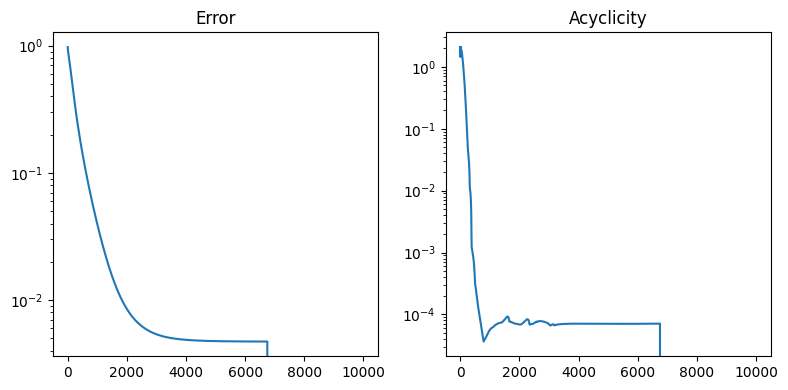

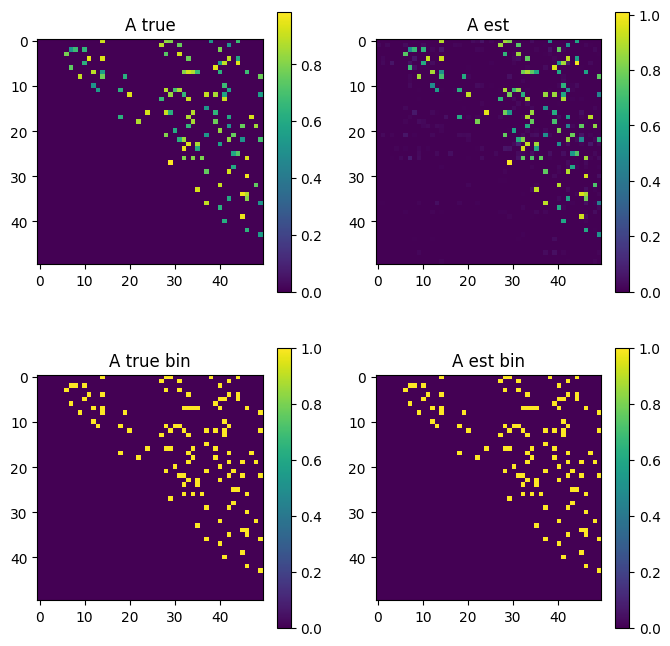

In [5]:
## Second set of hyperparams N = 50
args = {'stepsize': 5e-2, 'alpha': .5, 's': 1, 'lamb': np.sqrt(np.log(N)/M)*2e-2, 'max_iters': 10000}

print('lamb:', args['lamb'])

t_i = time.time()
model_noneg_dagma = Nonneg_dagma()
A_dagma2 = model_noneg_dagma.fit(X, **args, W_true=A)
t_solved = time.time() - t_i
print(f'Solved in {t_solved:3f} seconds')

# Plot description
thr = .2
plot_convergence(model_noneg_dagma)
plot_result(A, A_dagma2, thr)

## Comparing methods

In [6]:
###  500 samples - 50 nodes #####
N = 50

n_dags = 25
data_params = {
    'n_nodes': N,
    'n_samples': 500, # 1000,
    'graph_type': 'er',
    'edges': 2*N,
    'edge_type': 'positive',
    'w_range': (.5, 1),
    'var': 1/np.sqrt(N),
}

Exps = [
    {'model': Nonneg_dagma, 'args': {'stepsize': 5e-2, 'alpha': .1, 's': 1, 'lamb': 1e-3, 'max_iters': 10000},  # TOP!
     'norm_x': False, 'leg': 'DAGMA-CVX-False'},
    {'model': colide_ev, 'args': {'lambda1': .05, 'T': 4, 's': [1.0, .9, .8, .7], 'warm_iter': 2e4,
     'max_iter': 7e4, 'lr': .0003}, 'norm_x': False, 'leg': 'CoLiDe-Paper_regs-notnorm'},

    {'model': Nonneg_dagma, 'args': {'stepsize': 5e-1, 'alpha': .005, 's': 1, 'lamb': 1e-5, 'max_iters': 100000}, # TOP
     'norm_x': True, 'leg': 'DAGMA-CVX-alpha'},
    {'model': colide_ev, 'args': {'lambda1': 1e-3, 'T': 4, 's': [1.0, .9, .8, .7], 'warm_iter': 2e4,
     'max_iter': 7e4, 'lr': 0.003}, 'norm_x': False,  'leg': 'CoLiDe-norm'},    

]

# shd, fscore, err, acyc, runtime = run_exp(n_dags, data_params, Exps)

print('CPUs employed:', N_CPUS)

t_init = time.time()
results = Parallel(n_jobs=N_CPUS)(delayed(run_exps)(g, data_params, Exps, thr=.2, verb=False) for g in range(n_dags))
ellapsed_time = time.time() - t_init
print(f'----- Solved in {ellapsed_time:.3f} seconds -----')

# Extract results
shd, fscore, err, acyc, runtime = zip(*results)
metrics = {'shd': shd, 'fscore': fscore, 'err': err, 'acyc': acyc, 'time': runtime}


CPUs employed: 32


3: Fidelity: 7.070  -  Fidelity (norm): 0.273
23: Fidelity: 7.042  -  Fidelity (norm): 0.265
2: Fidelity: 7.053  -  Fidelity (norm): 0.299
16: Fidelity: 7.109  -  Fidelity (norm): 0.272
11: Fidelity: 7.090  -  Fidelity (norm): 0.296
0: Fidelity: 6.998  -  Fidelity (norm): 0.169
1: Fidelity: 7.020  -  Fidelity (norm): 0.277
19: Fidelity: 7.100  -  Fidelity (norm): 0.325
4: Fidelity: 7.097  -  Fidelity (norm): 0.337
21: Fidelity: 7.092  -  Fidelity (norm): 0.390
22: Fidelity: 7.117  -  Fidelity (norm): 0.357
24: Fidelity: 7.077  -  Fidelity (norm): 0.238
7: Fidelity: 7.156  -  Fidelity (norm): 0.215
12: Fidelity: 7.124  -  Fidelity (norm): 0.233
5: Fidelity: 7.049  -  Fidelity (norm): 0.335
9: Fidelity: 7.110  -  Fidelity (norm): 0.371
8: Fidelity: 7.073  -  Fidelity (norm): 0.185
20: Fidelity: 6.989  -  Fidelity (norm): 0.280
14: Fidelity: 7.036  -  Fidelity (norm): 0.337
18: Fidelity: 7.014  -  Fidelity (norm): 0.299
10: Fidelity: 6.994  -  Fidelity (norm): 0.221
15: Fidelity: 7.041  -

100%|██████████| 130000/130000.0 [00:03<00:00, 41218.78it/s]
100%|██████████| 130000/130000.0 [00:03<00:00, 34650.59it/s]
100%|██████████| 130000/130000.0 [00:04<00:00, 32245.28it/s]
100%|██████████| 130000/130000.0 [00:04<00:00, 30681.01it/s]
100%|██████████| 130000/130000.0 [00:04<00:00, 30489.39it/s]
100%|██████████| 130000/130000.0 [00:03<00:00, 33347.31it/s]
100%|██████████| 130000/130000.0 [00:04<00:00, 32383.26it/s]
100%|██████████| 130000/130000.0 [00:03<00:00, 32546.30it/s]
100%|██████████| 130000/130000.0 [00:04<00:00, 29550.03it/s]
100%|██████████| 130000/130000.0 [00:04<00:00, 28885.87it/s]
100%|██████████| 130000/130000.0 [00:04<00:00, 29506.51it/s]
100%|██████████| 130000/130000.0 [00:04<00:00, 27407.67it/s]
100%|██████████| 130000/130000.0 [00:04<00:00, 29147.40it/s]
100%|██████████| 130000/130000.0 [00:04<00:00, 27278.02it/s]
100%|██████████| 130000/130000.0 [00:04<00:00, 26165.88it/s]
100%|██████████| 130000/130000.0 [00:05<00:00, 23793.19it/s]
100%|██████████| 130000/

----- Solved in 15.0 seconds -----


100%|██████████| 130000/130000.0 [00:02<00:00, 64974.12it/s]


In [7]:
exps_leg = [exp['leg'] for exp in Exps]
utils.display_results(exps_leg, metrics, agg='mean')
utils.display_results(exps_leg, metrics, agg='median')

,leg,shd,fscore,err,acyc,time
0,DAGMA-CVX-False,0.36,0.997943,0.013694,0.004278,1.463188
1,CoLiDe-Paper_regs-notnorm,2.32,0.983492,0.038563,0.000005,4.746042
2,DAGMA-CVX-alpha,2.28,0.986867,0.031797,0.000979,2.669187
3,CoLiDe-norm,13.80,0.928596,0.107107,0.000007,2.093293


,leg,shd,fscore,err,acyc,time
0,DAGMA-CVX-False,0.0,1.000000,0.012015,0.003384,1.467098
1,CoLiDe-Paper_regs-notnorm,1.0,0.988636,0.032808,0.000005,4.636536
2,DAGMA-CVX-alpha,0.0,1.000000,0.023068,0.000450,2.486808
3,CoLiDe-norm,14.0,0.929825,0.099042,0.000007,2.092952


In [8]:
###  1000 samples - 50 nodes  #####
N = 50

n_dags = 25
data_params = {
    'n_nodes': N,
    'n_samples': 1000, # 1000,
    'graph_type': 'er',
    'edges': 2*N,
    'edge_type': 'positive',
    'w_range': (.5, 1),
    'var': 1/np.sqrt(N),
}

Exps = [
    {'model': Nonneg_dagma, 'args': {'stepsize': 5e-2, 'alpha': .1, 's': 1, 'lamb': 1e-3, 'max_iters': 10000},  # TOP!
     'norm_x': False, 'leg': 'DAGMA-CVX-False'},
    {'model': colide_ev, 'args': {'lambda1': .05, 'T': 4, 's': [1.0, .9, .8, .7], 'warm_iter': 2e4,
     'max_iter': 7e4, 'lr': .0003}, 'norm_x': False, 'leg': 'CoLiDe-Paper_regs-notnorm'},

    {'model': Nonneg_dagma, 'args': {'stepsize': 5e-1, 'alpha': .005, 's': 1, 'lamb': 1e-5, 'max_iters': 100000}, # TOP
     'norm_x': True, 'leg': 'DAGMA-CVX-alpha'},
    {'model': colide_ev, 'args': {'lambda1': 1e-3, 'T': 4, 's': [1.0, .9, .8, .7], 'warm_iter': 2e4,
     'max_iter': 7e4, 'lr': 0.003}, 'norm_x': False,  'leg': 'CoLiDe-norm'},    

]

# shd, fscore, err, acyc, runtime = run_exp(n_dags, data_params, Exps)

print('CPUs employed:', N_CPUS)

t_init = time.time()
results = Parallel(n_jobs=N_CPUS)(delayed(run_exps)(g, data_params, Exps, thr=.2, verb=False) for g in range(n_dags))
ellapsed_time = time.time() - t_init
print(f'----- Solved in {ellapsed_time:.3} seconds -----')

# Extract results
shd, fscore, err, acyc, runtime = zip(*results)
metrics = {'shd': shd, 'fscore': fscore, 'err': err, 'acyc': acyc, 'time': runtime}


CPUs employed: 32
7: Fidelity: 7.130  -  Fidelity (norm): 0.293
8: Fidelity: 7.130  -  Fidelity (norm): 0.383
9: Fidelity: 7.130  -  Fidelity (norm): 0.283
10: Fidelity: 7.130  -  Fidelity (norm): 0.373
15: Fidelity: 7.130  -  Fidelity (norm): 0.254
16: Fidelity: 7.130  -  Fidelity (norm): 0.324
11: Fidelity: 7.130  -  Fidelity (norm): 0.199
12: Fidelity: 7.130  -  Fidelity (norm): 0.228
13: Fidelity: 7.130  -  Fidelity (norm): 0.268
14: Fidelity: 7.130  -  Fidelity (norm): 0.23918: Fidelity: 7.130  -  Fidelity (norm): 0.243
19: Fidelity: 7.130  -  Fidelity (norm): 0.290
21: Fidelity: 7.130  -  Fidelity (norm): 0.268

20: Fidelity: 7.130  -  Fidelity (norm): 0.181
17: Fidelity: 7.130  -  Fidelity (norm): 0.294
22: Fidelity: 7.130  -  Fidelity (norm): 0.133
23: Fidelity: 7.130  -  Fidelity (norm): 0.196
24: Fidelity: 7.130  -  Fidelity (norm): 0.213


2: Fidelity: 7.037  -  Fidelity (norm): 0.257
6: Fidelity: 7.116  -  Fidelity (norm): 0.288
1: Fidelity: 7.039  -  Fidelity (norm): 0.280
0: Fidelity: 7.100  -  Fidelity (norm): 0.295


  0%|          | 0/130000.0 [00:00<?, ?it/s]6270.65it/s]

5: Fidelity: 7.054  -  Fidelity (norm): 0.276
4: Fidelity: 7.021  -  Fidelity (norm): 0.281
3: Fidelity: 6.965  -  Fidelity (norm): 0.230


100%|██████████| 130000/130000.0 [00:03<00:00, 37418.19it/s] 
100%|██████████| 130000/130000.0 [00:04<00:00, 31978.52it/s]
100%|██████████| 130000/130000.0 [00:03<00:00, 34471.35it/s]
100%|██████████| 130000/130000.0 [00:04<00:00, 29441.32it/s]
100%|██████████| 130000/130000.0 [00:04<00:00, 32041.13it/s]
100%|██████████| 130000/130000.0 [00:04<00:00, 28235.56it/s]
100%|██████████| 130000/130000.0 [00:03<00:00, 38677.97it/s]
100%|██████████| 130000/130000.0 [00:03<00:00, 38781.38it/s]
100%|██████████| 130000/130000.0 [00:03<00:00, 33625.44it/s]
100%|██████████| 130000/130000.0 [00:04<00:00, 31404.64it/s]
100%|██████████| 130000/130000.0 [00:03<00:00, 34137.30it/s]
100%|██████████| 130000/130000.0 [00:04<00:00, 30651.64it/s]
100%|██████████| 130000/130000.0 [00:04<00:00, 31866.89it/s]
100%|██████████| 130000/130000.0 [00:04<00:00, 29979.06it/s]
100%|██████████| 130000/130000.0 [00:05<00:00, 24759.09it/s]
100%|██████████| 130000/130000.0 [00:05<00:00, 25901.10it/s]
100%|██████████| 130000

----- Solved in 13.6 seconds -----


100%|██████████| 130000/130000.0 [00:02<00:00, 60235.93it/s]


In [9]:
# M = 1000
exps_leg = [exp['leg'] for exp in Exps]
utils.display_results(exps_leg, metrics, agg='mean')
utils.display_results(exps_leg, metrics, agg='median')

,leg,shd,fscore,err,acyc,time
0,DAGMA-CVX-False,4.88,0.960582,0.070808,0.083495,1.401777
1,CoLiDe-Paper_regs-notnorm,2.12,0.982545,0.034697,0.000005,4.710312
2,DAGMA-CVX-alpha,1.88,0.987940,0.021884,0.000404,2.495416
3,CoLiDe-norm,13.36,0.928209,0.089978,0.000006,2.135892


,leg,shd,fscore,err,acyc,time
0,DAGMA-CVX-False,0.0,1.000000,0.005357,0.002034,1.353633
1,CoLiDe-Paper_regs-notnorm,1.0,0.988372,0.021478,0.000005,4.416238
2,DAGMA-CVX-alpha,0.0,1.000000,0.013345,0.000241,2.503847
3,CoLiDe-norm,9.0,0.945946,0.076466,0.000006,2.107001


### 1000 samples - 100 nodes

In [10]:
###  1000 samples - 100 nodes  #####
N = 100

n_dags = 25
data_params = {
    'n_nodes': N,
    'n_samples': 1000, # 1000,
    'graph_type': 'er',
    'edges': 2*N,
    'edge_type': 'positive',
    'w_range': (.5, 1),
    'var': 1/np.sqrt(N),
}

Exps = [
    {'model': Nonneg_dagma, 'args': {'stepsize': 5e-2, 'alpha': .1, 's': 1, 'lamb': 1e-3, 'max_iters': 10000},  # TOP!
     'norm_x': False, 'leg': 'DAGMA-CVX-False'},
    {'model': colide_ev, 'args': {'lambda1': .05, 'T': 4, 's': [1.0, .9, .8, .7], 'warm_iter': 2e4,
     'max_iter': 7e4, 'lr': .0003}, 'norm_x': False, 'leg': 'CoLiDe-Paper_regs-notnorm'},

    {'model': Nonneg_dagma, 'args': {'stepsize': 5e-1, 'alpha': .005, 's': 1, 'lamb': 1e-5, 'max_iters': 100000}, # TOP
     'norm_x': True, 'leg': 'DAGMA-CVX-alpha'},
    {'model': colide_ev, 'args': {'lambda1': 1e-3, 'T': 4, 's': [1.0, .9, .8, .7], 'warm_iter': 2e4,
     'max_iter': 7e4, 'lr': 0.003}, 'norm_x': False,  'leg': 'CoLiDe-norm'},    

]

print('CPUs employed:', N_CPUS)

t_init = time.time()
results = Parallel(n_jobs=N_CPUS)(delayed(run_exps)(g, data_params, Exps, thr=.2, verb=False) for g in range(n_dags))
ellapsed_time = time.time() - t_init
print(f'----- Solved in {ellapsed_time:.3} seconds -----')

# Extract results
shd, fscore, err, acyc, runtime = zip(*results)
metrics = {'shd': shd, 'fscore': fscore, 'err': err, 'acyc': acyc, 'time': runtime}


CPUs employed: 32
0: Fidelity: 9.956  -  Fidelity (norm): 0.253
1: Fidelity: 9.956  -  Fidelity (norm): 0.243
2: Fidelity: 9.956  -  Fidelity (norm): 0.267
4: Fidelity: 9.956  -  Fidelity (norm): 0.228
5: Fidelity: 9.956  -  Fidelity (norm): 0.184
7: Fidelity: 9.956  -  Fidelity (norm): 0.239
6: Fidelity: 9.956  -  Fidelity (norm): 0.256
3: Fidelity: 9.956  -  Fidelity (norm): 0.276
9: Fidelity: 9.956  -  Fidelity (norm): 0.278
8: Fidelity: 9.956  -  Fidelity (norm): 0.219
10: Fidelity: 9.956  -  Fidelity (norm): 0.239
11: Fidelity: 9.956  -  Fidelity (norm): 0.236
12: Fidelity: 9.956  -  Fidelity (norm): 0.298
15: Fidelity: 9.956  -  Fidelity (norm): 0.279
17: Fidelity: 9.956  -  Fidelity (norm): 0.279
16: Fidelity: 9.956  -  Fidelity (norm): 0.302
13: Fidelity: 9.956  -  Fidelity (norm): 0.271
14: Fidelity: 9.956  -  Fidelity (norm): 0.222
18: Fidelity: 9.956  -  Fidelity (norm): 0.247
21: Fidelity: 9.956  -  Fidelity (norm): 0.190
20: Fidelity: 9.956  -  Fidelity (norm): 0.279
19: F

100%|██████████| 130000/130000.0 [00:50<00:00, 2581.21it/s]
100%|██████████| 130000/130000.0 [00:55<00:00, 2334.05it/s]
100%|██████████| 130000/130000.0 [01:09<00:00, 1871.28it/s]
100%|██████████| 130000/130000.0 [01:13<00:00, 1771.94it/s]
100%|██████████| 130000/130000.0 [01:17<00:00, 1687.51it/s]
100%|██████████| 130000/130000.0 [01:16<00:00, 1689.80it/s]
100%|██████████| 130000/130000.0 [01:25<00:00, 1514.29it/s]
100%|██████████| 130000/130000.0 [01:26<00:00, 1511.57it/s]
100%|██████████| 130000/130000.0 [01:17<00:00, 1673.20it/s] 
100%|██████████| 130000/130000.0 [01:17<00:00, 1686.61it/s]
100%|██████████| 130000/130000.0 [01:25<00:00, 1519.26it/s]
100%|██████████| 130000/130000.0 [01:31<00:00, 1418.91it/s]
100%|██████████| 130000/130000.0 [01:40<00:00, 1294.04it/s]
100%|██████████| 130000/130000.0 [01:39<00:00, 1301.41it/s]
100%|██████████| 130000/130000.0 [01:47<00:00, 1209.14it/s]
100%|██████████| 130000/130000.0 [01:50<00:00, 1174.98it/s]
100%|██████████| 130000/130000.0 [00:43

----- Solved in 2.06e+02 seconds -----


100%|██████████| 130000/130000.0 [00:10<00:00, 12111.66it/s]


In [11]:
# M = 1000
exps_leg = [exp['leg'] for exp in Exps]
utils.display_results(exps_leg, metrics, agg='mean')
utils.display_results(exps_leg, metrics, agg='median')

,leg,shd,fscore,err,acyc,time
0,DAGMA-CVX-False,2.00,0.992992,0.012515,0.003800,12.049977
1,CoLiDe-Paper_regs-notnorm,2.72,0.988458,0.029073,0.000007,98.624814
2,DAGMA-CVX-alpha,9.92,0.969190,0.040334,0.000639,41.542339
3,CoLiDe-norm,25.00,0.930905,0.103691,0.000015,26.379198


,leg,shd,fscore,err,acyc,time
0,DAGMA-CVX-False,1.0,0.994764,0.010510,0.003125,13.130510
1,CoLiDe-Paper_regs-notnorm,2.0,0.990566,0.026319,0.000006,99.895767
2,DAGMA-CVX-alpha,10.0,0.966752,0.037676,0.000587,42.851790
3,CoLiDe-norm,27.0,0.924171,0.100244,0.000015,27.109844


### 4N edges

In [12]:
###  1000 samples - 50 nodes  #####
N = 50

n_dags = 25
data_params = {
    'n_nodes': N,
    'n_samples': 1000, # 1000,
    'graph_type': 'er',
    'edges': 4*N,
    'edge_type': 'positive',
    'w_range': (.5, 1),
    'var': 1/np.sqrt(N),
}

Exps = [
    {'model': Nonneg_dagma, 'args': {'stepsize': 5e-2, 'alpha': .1, 's': 1, 'lamb': 1e-3, 'max_iters': 10000},  # TOP!
     'norm_x': False, 'leg': 'DAGMA-CVX-False'},
    {'model': colide_ev, 'args': {'lambda1': .05, 'T': 4, 's': [1.0, .9, .8, .7], 'warm_iter': 2e4,
     'max_iter': 7e4, 'lr': .0003}, 'norm_x': False, 'leg': 'CoLiDe-Paper_regs-notnorm'},

    {'model': Nonneg_dagma, 'args': {'stepsize': 5e-1, 'alpha': .005, 's': 1, 'lamb': 1e-5, 'max_iters': 100000}, # TOP
     'norm_x': True, 'leg': 'DAGMA-CVX-alpha'},
    {'model': colide_ev, 'args': {'lambda1': 1e-3, 'T': 4, 's': [1.0, .9, .8, .7], 'warm_iter': 2e4,
     'max_iter': 7e4, 'lr': 0.003}, 'norm_x': False,  'leg': 'CoLiDe-norm'},    

]

print('CPUs employed:', N_CPUS)

t_init = time.time()
results = Parallel(n_jobs=N_CPUS)(delayed(run_exps)(g, data_params, Exps, thr=.2, verb=False) for g in range(n_dags))
ellapsed_time = time.time() - t_init
print(f'----- Solved in {ellapsed_time:.3} seconds -----')

# Extract results
shd, fscore, err, acyc, runtime = zip(*results)
metrics = {'shd': shd, 'fscore': fscore, 'err': err, 'acyc': acyc, 'time': runtime}


CPUs employed: 32
0: Fidelity: 7.130  -  Fidelity (norm): 0.015
1: Fidelity: 7.130  -  Fidelity (norm): 0.008
2: Fidelity: 7.130  -  Fidelity (norm): 0.016
4: Fidelity: 7.130  -  Fidelity (norm): 0.034
3: Fidelity: 7.130  -  Fidelity (norm): 0.024
5: Fidelity: 7.130  -  Fidelity (norm): 0.024
7: Fidelity: 7.130  -  Fidelity (norm): 0.021
6: Fidelity: 7.130  -  Fidelity (norm): 0.030
9: Fidelity: 7.130  -  Fidelity (norm): 0.050
12: Fidelity: 7.130  -  Fidelity (norm): 0.023
8: Fidelity: 7.130  -  Fidelity (norm): 0.011
10: Fidelity: 7.130  -  Fidelity (norm): 0.049
11: Fidelity: 7.130  -  Fidelity (norm): 0.013
13: Fidelity: 7.130  -  Fidelity (norm): 0.012
14: Fidelity: 7.130  -  Fidelity (norm): 0.050
15: Fidelity: 7.130  -  Fidelity (norm): 0.022
16: Fidelity: 7.130  -  Fidelity (norm): 0.044
18: Fidelity: 7.130  -  Fidelity (norm): 0.020
19: Fidelity: 7.130  -  Fidelity (norm): 0.015
17: Fidelity: 7.130  -  Fidelity (norm): 0.018
20: Fidelity: 7.130  -  Fidelity (norm): 0.009
21: F

100%|██████████| 130000/130000.0 [00:04<00:00, 30805.06it/s]
100%|██████████| 130000/130000.0 [00:05<00:00, 24707.72it/s]
100%|██████████| 130000/130000.0 [00:05<00:00, 22774.19it/s]
100%|██████████| 130000/130000.0 [00:05<00:00, 24831.33it/s]
100%|██████████| 130000/130000.0 [00:05<00:00, 21838.57it/s]
100%|██████████| 130000/130000.0 [00:05<00:00, 23379.05it/s]
100%|██████████| 130000/130000.0 [00:05<00:00, 22495.12it/s]
100%|██████████| 130000/130000.0 [00:05<00:00, 22176.49it/s]
100%|██████████| 130000/130000.0 [00:05<00:00, 22467.06it/s]
100%|██████████| 130000/130000.0 [00:06<00:00, 20058.90it/s]
100%|██████████| 130000/130000.0 [00:06<00:00, 21029.79it/s]
100%|██████████| 130000/130000.0 [00:06<00:00, 19984.68it/s]
100%|██████████| 130000/130000.0 [00:06<00:00, 21025.46it/s]
100%|██████████| 130000/130000.0 [00:06<00:00, 19375.53it/s]
100%|██████████| 130000/130000.0 [00:06<00:00, 19723.87it/s]
100%|██████████| 130000/130000.0 [00:06<00:00, 19883.97it/s]
100%|██████████| 130000/

----- Solved in 46.1 seconds -----


100%|██████████| 130000/130000.0 [00:16<00:00, 7665.27it/s]


In [13]:
exps_leg = [exp['leg'] for exp in Exps]
utils.display_results(exps_leg, metrics, agg='mean')
utils.display_results(exps_leg, metrics, agg='median')

,leg,shd,fscore,err,acyc,time
0,DAGMA-CVX-False,173.68,0.298328,0.898241,10.216998,1.793065
1,CoLiDe-Paper_regs-notnorm,39.92,0.881471,0.208090,0.000072,6.548977
2,DAGMA-CVX-alpha,26.16,0.924567,0.126444,0.000016,16.662416
3,CoLiDe-norm,45.36,0.883328,0.144866,0.000031,7.731887


,leg,shd,fscore,err,acyc,time
0,DAGMA-CVX-False,200.0,0.193309,0.889917,11.210179,1.845239
1,CoLiDe-Paper_regs-notnorm,40.0,0.880435,0.203274,0.000066,6.505826
2,DAGMA-CVX-alpha,23.0,0.933025,0.109680,0.000006,17.116187
3,CoLiDe-norm,35.0,0.896725,0.142875,0.000019,7.861630


In [14]:
###  1000 samples - 100 nodes  #####
N = 100

n_dags = 25
data_params = {
    'n_nodes': N,
    'n_samples': 1000, # 1000,
    'graph_type': 'er',
    'edges': 4*N,
    'edge_type': 'positive',
    'w_range': (.5, 1),
    'var': 1/np.sqrt(N),
}

Exps = [
    {'model': Nonneg_dagma, 'args': {'stepsize': 5e-2, 'alpha': .1, 's': 1, 'lamb': 1e-3, 'max_iters': 10000},  # TOP!
     'norm_x': False, 'leg': 'DAGMA-CVX-False'},
    {'model': colide_ev, 'args': {'lambda1': .05, 'T': 4, 's': [1.0, .9, .8, .7], 'warm_iter': 2e4,
     'max_iter': 7e4, 'lr': .0003}, 'norm_x': False, 'leg': 'CoLiDe-Paper_regs-notnorm'},

    {'model': Nonneg_dagma, 'args': {'stepsize': 5e-1, 'alpha': .005, 's': 1, 'lamb': 1e-5, 'max_iters': 100000}, # TOP
     'norm_x': True, 'leg': 'DAGMA-CVX-alpha'},
    {'model': colide_ev, 'args': {'lambda1': 1e-3, 'T': 4, 's': [1.0, .9, .8, .7], 'warm_iter': 2e4,
     'max_iter': 7e4, 'lr': 0.003}, 'norm_x': False,  'leg': 'CoLiDe-norm'},    

]

# shd, fscore, err, acyc, runtime = run_exp(n_dags, data_params, Exps)

print('CPUs employed:', N_CPUS)

t_init = time.time()
results = Parallel(n_jobs=N_CPUS)(delayed(run_exps)(g, data_params, Exps, thr=.2, verb=False) for g in range(n_dags))
ellapsed_time = time.time() - t_init
print(f'----- Solved in {ellapsed_time:.3} seconds -----')

# Extract results
shd, fscore, err, acyc, runtime = zip(*results)
metrics = {'shd': shd, 'fscore': fscore, 'err': err, 'acyc': acyc, 'time': runtime}


CPUs employed: 32
7: Fidelity: 9.956  -  Fidelity (norm): 0.028
8: Fidelity: 9.956  -  Fidelity (norm): 0.008
10: Fidelity: 9.956  -  Fidelity (norm): 0.026
9: Fidelity: 9.956  -  Fidelity (norm): 0.045
11: Fidelity: 9.956  -  Fidelity (norm): 0.015
15: Fidelity: 9.956  -  Fidelity (norm): 0.023
12: Fidelity: 9.956  -  Fidelity (norm): 0.017
13: Fidelity: 9.956  -  Fidelity (norm): 0.030
14: Fidelity: 9.956  -  Fidelity (norm): 0.009
16: Fidelity: 9.956  -  Fidelity (norm): 0.019
18: Fidelity: 9.956  -  Fidelity (norm): 0.010
19: Fidelity: 9.956  -  Fidelity (norm): 0.014
17: Fidelity: 9.956  -  Fidelity (norm): 0.020
21: Fidelity: 9.956  -  Fidelity (norm): 0.016
20: Fidelity: 9.956  -  Fidelity (norm): 0.022
22: Fidelity: 9.956  -  Fidelity (norm): 0.007
23: Fidelity: 9.956  -  Fidelity (norm): 0.015
24: Fidelity: 9.956  -  Fidelity (norm): 0.027
1: Fidelity: 10.006  -  Fidelity (norm): 0.010
3: Fidelity: 10.038  -  Fidelity (norm): 0.008
5: Fidelity: 9.941  -  Fidelity (norm): 0.012

100%|██████████| 130000/130000.0 [01:25<00:00, 1528.73it/s] 
100%|██████████| 130000/130000.0 [01:44<00:00, 1243.60it/s]
100%|██████████| 130000/130000.0 [01:56<00:00, 1114.04it/s]  
100%|██████████| 130000/130000.0 [01:55<00:00, 1127.17it/s]
100%|██████████| 130000/130000.0 [02:14<00:00, 969.53it/s]]
100%|██████████| 130000/130000.0 [02:01<00:00, 1065.60it/s]
100%|██████████| 130000/130000.0 [02:09<00:00, 1004.43it/s]
100%|██████████| 130000/130000.0 [02:14<00:00, 967.00it/s]  
100%|██████████| 130000/130000.0 [02:21<00:00, 919.59it/s] 
100%|██████████| 130000/130000.0 [02:17<00:00, 944.46it/s]  
100%|██████████| 130000/130000.0 [02:27<00:00, 878.60it/s]]
100%|██████████| 130000/130000.0 [02:19<00:00, 935.07it/s]
100%|██████████| 130000/130000.0 [02:22<00:00, 911.06it/s] 
100%|██████████| 130000/130000.0 [02:22<00:00, 911.96it/s] 
100%|██████████| 130000/130000.0 [02:28<00:00, 873.31it/s]  
100%|██████████| 130000/130000.0 [02:33<00:00, 849.61it/s]]
100%|██████████| 130000/130000.0 [0

----- Solved in 5.31e+02 seconds -----


100%|██████████| 130000/130000.0 [03:30<00:00, 616.76it/s] 


In [15]:
# M = 1000
exps_leg = [exp['leg'] for exp in Exps]
utils.display_results(exps_leg, metrics, agg='mean')
utils.display_results(exps_leg, metrics, agg='median')

,leg,shd,fscore,err,acyc,time
0,DAGMA-CVX-False,417.28,0.282983,0.956588,15.445216,13.209178
1,CoLiDe-Paper_regs-notnorm,39.32,0.939098,0.116459,0.000061,146.081003
2,DAGMA-CVX-alpha,81.68,0.882328,0.199845,0.000073,146.320318
3,CoLiDe-norm,78.44,0.898579,0.129781,0.000040,155.222353


,leg,shd,fscore,err,acyc,time
0,DAGMA-CVX-False,407.0,0.190099,0.881961,17.039774,14.672722
1,CoLiDe-Paper_regs-notnorm,39.0,0.939791,0.116373,0.000055,142.695194
2,DAGMA-CVX-alpha,64.0,0.902564,0.155578,0.000074,148.825434
3,CoLiDe-norm,73.0,0.903371,0.122768,0.000040,160.400560
